In [101]:
import pretty_midi
import numpy as np
from scipy.spatial.distance import cosine

import glob
from tqdm import tqdm

# Time-pitch

In [102]:
def compute_time_pitch_profile(pm):
    """
    Cífka: time-pitch profile
    (start(b) - start(a), pitch(b) - pitch(a))
    Bins: 24 x 41  ∈ [0,4) x {-20,...,20}
    """
    pairs = []
    for inst in pm.instruments:
        notes = sorted(inst.notes, key=lambda n: n.start)
        for i in range(len(notes)):
            for j in range(i + 1, len(notes)):
                dt = notes[j].start - notes[i].start
                if dt >= 4.0:
                    break  # fuera del rango
                dpitch = notes[j].pitch - notes[i].pitch
                if abs(dpitch) > 20:
                    continue
                pairs.append((dt, dpitch))
                
    hist, _, _ = np.histogram2d(
        [p[0] for p in pairs],
        [p[1] for p in pairs],
        bins=[24, 41],
        range=[[0, 4], [-20, 21]]
    )
    return hist


# Onset-duration

In [103]:
def compute_onset_duration_profile(pm):
    """
    Cífka: onset-duration profile
    (start mod 4, duration)
    Bins: 24 x 12  ∈ [0,4) x [0,2)
    """
    onsets = []
    durations = []
    for inst in pm.instruments:
        for note in inst.notes:
            beat_pos = note.start % 4.0
            dur = note.end - note.start
            if dur >= 2.0:
                dur = 1.999  # evitar out-of-range
            onsets.append(beat_pos)
            durations.append(dur)
            
    hist, _, _ = np.histogram2d(
        onsets,
        durations,
        bins=[24, 12],
        range=[[0, 4], [0, 2]]
    )
    return hist


# Onset-velocity

In [104]:
def compute_onset_velocity_profile(pm):
    """
    Cífka: onset-velocity profile
    (start mod 4, velocity)
    Bins: 24 x 8  ∈ [0,4) x {1,...,127}
    """
    onsets = []
    velocities = []
    for inst in pm.instruments:
        for note in inst.notes:
            beat_pos = note.start % 4.0
            vel = note.velocity
            onsets.append(beat_pos)
            velocities.append(vel)
            
    hist, _, _ = np.histogram2d(
        onsets,
        velocities,
        bins=[24, 8],
        range=[[0, 4], [1, 128]]
    )
    return hist


# Onset-drum

In [115]:
def compute_onset_drum_profile(pm):
    """
    Cífka: onset-drum profile
    (start mod 4, pitch)
    Bins: 24 x 128  ∈ [0,4) x {0,...,127}
    """
    onsets = []
    pitches = []
    for inst in pm.instruments:
        if not inst.is_drum:
            continue
        for note in inst.notes:
            beat_pos = note.start % 4.0
            onsets.append(beat_pos)
            pitches.append(note.pitch)
            
    hist, _, _ = np.histogram2d(
        onsets,
        pitches,
        bins=[24, 128],
        range=[[0, 4], [0, 128]]
    )
    return hist


# Cosine similarity

In [106]:
def cosine_similarity_profile(profile, corpus_mean_profile):
    """
    Aplana y compara.
    """
    vec1 = profile.flatten()
    vec2 = corpus_mean_profile.flatten()
    return 1 - cosine(vec1, vec2)

## Conseguir medias

In [6]:
def compute_corpus_style_profiles(midi_folder):
    files = glob.glob(f"{midi_folder}/*.mid")
    
    time_pitch_profiles = []
    onset_duration_profiles = []
    onset_velocity_profiles = []
    onset_drum_profiles = []

    for f in tqdm(files, desc="Procesando corpus"):
        try:
            pm = pretty_midi.PrettyMIDI(f)
            time_pitch_profiles.append(compute_time_pitch_profile(pm))
            onset_duration_profiles.append(compute_onset_duration_profile(pm))
            onset_velocity_profiles.append(compute_onset_velocity_profile(pm))
            onset_drum_profiles.append(compute_onset_drum_profile(pm))
        except Exception as e:
            print(f"Error con {f}: {e}")

    corpus_profiles = {
        "time_pitch": np.mean(time_pitch_profiles, axis=0),
        "onset_duration": np.mean(onset_duration_profiles, axis=0),
        "onset_velocity": np.mean(onset_velocity_profiles, axis=0),
        "onset_drum": np.mean(onset_drum_profiles, axis=0)
    }
    return corpus_profiles

In [7]:
# Cambia la ruta por la de tu corpus de entrenamiento:
corpus_means = compute_corpus_style_profiles("MIDI_Files_min_aug")

# Para guardar y reutilizar:
np.savez("corpus_style_profiles.npz",
         time_pitch=corpus_means["time_pitch"],
         onset_duration=corpus_means["onset_duration"],
         onset_velocity=corpus_means["onset_velocity"],
         onset_drum=corpus_means["onset_drum"])

print("✅ Perfiles promedio guardados en corpus_style_profiles.npz")

Procesando corpus: 100%|██████████| 400/400 [00:33<00:00, 11.82it/s]

✅ Perfiles promedio guardados en corpus_style_profiles.npz


# Plotear perfiles

In [107]:
import matplotlib.pyplot as plt
import numpy as np

def plot_profile_heatmap(profile, title="Perfil estilístico", ejes=("Eje X", "Eje Y")):
    """
    profile: matriz 2D con shape (bins_y, bins_x)
    Ajusta la cuadrícula según el tamaño de la matriz.
    """
    bins_y, bins_x = profile.shape

    plt.figure(figsize=(max(6, bins_x/5), max(4, bins_y/5)))
    plt.imshow(profile, origin='lower', aspect='auto', cmap='magma')

    # Ticks mayores cada ~5 o menos si pocos bins
    step_x = max(1, bins_x // 10)
    step_y = max(1, bins_y // 10)
    plt.xticks(np.arange(0, bins_x, step_x))
    plt.yticks(np.arange(0, bins_y, step_y))

    # Cuadrícula en los bordes de cada bin (ticks menores)
    #plt.gca().set_xticks(np.arange(-0.5, bins_x, 1), minor=True)
    #plt.gca().set_yticks(np.arange(-0.5, bins_y, 1), minor=True)
    #plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)

    #plt.grid(which='major', color='k', linestyle='--', linewidth=0.5)
    plt.gca().grid(False)
    plt.title(title)
    plt.xlabel(ejes[0])
    plt.ylabel(ejes[1])
    plt.colorbar(label="Frecuencia normalizada")
    plt.show()


# Uso

In [124]:
cancion = "piratas"
#pm = pretty_midi.PrettyMIDI("metrics test/" + cancion + "__zelda__remix.mid")
#pm = pretty_midi.PrettyMIDI("metrics test/zelda.mid")
pm = pretty_midi.PrettyMIDI("metrics test/" + cancion + ".mid")

tp_profile = compute_time_pitch_profile(pm)
od_profile = compute_onset_duration_profile(pm)
ov_profile = compute_onset_velocity_profile(pm)
drum_profile = compute_onset_drum_profile(pm)

# Supón que tienes corpus_means:
# tp_mean, od_mean, ov_mean, drum_mean
# Cargar el archivo NPZ
corpus = np.load("corpus_style_profiles.npz")

# Acceder a cada perfil por su clave
tp_mean = corpus['time_pitch']
od_mean = corpus['onset_duration']
ov_mean = corpus['onset_velocity']
drum_mean = corpus['onset_drum']

tp_fit = cosine_similarity_profile(tp_profile, tp_mean)
od_fit = cosine_similarity_profile(od_profile, od_mean)
ov_fit = cosine_similarity_profile(ov_profile, ov_mean)
drum_fit = cosine_similarity_profile(drum_profile, drum_mean)


In [125]:
print("- Time-Pitch Fit:", tp_fit)
print("- Onset-Duration Fit:", od_fit)
print("- Onset-Velocity Fit:", ov_fit)
print("- Onset-Drum Fit:", drum_fit)

- Time-Pitch Fit: 0.7654535054112046
- Onset-Duration Fit: 0.8554302993171394
- Onset-Velocity Fit: 0.4954593728440646
- Onset-Drum Fit: nan


## Pintar perfiles

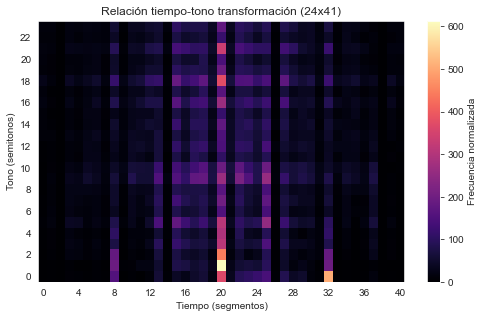

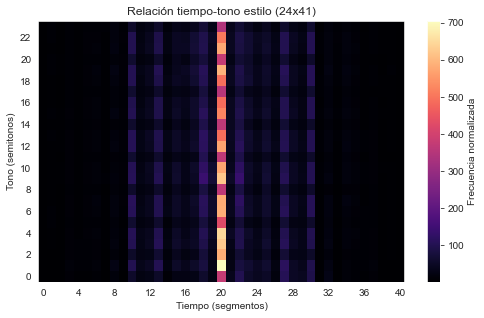

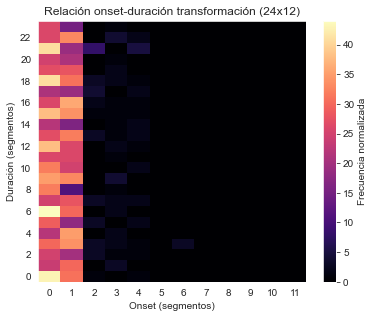

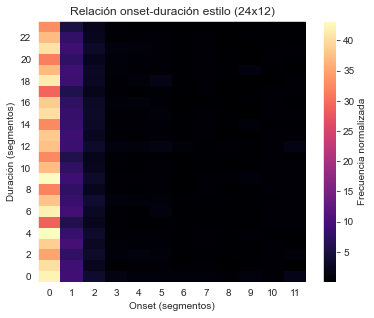

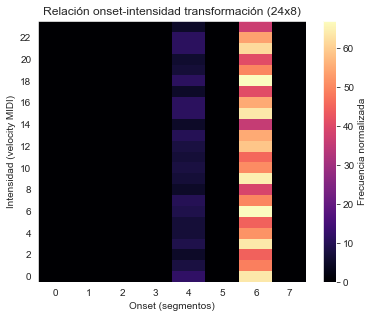

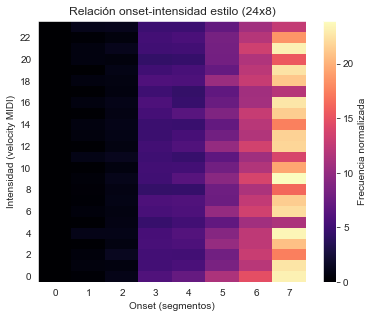

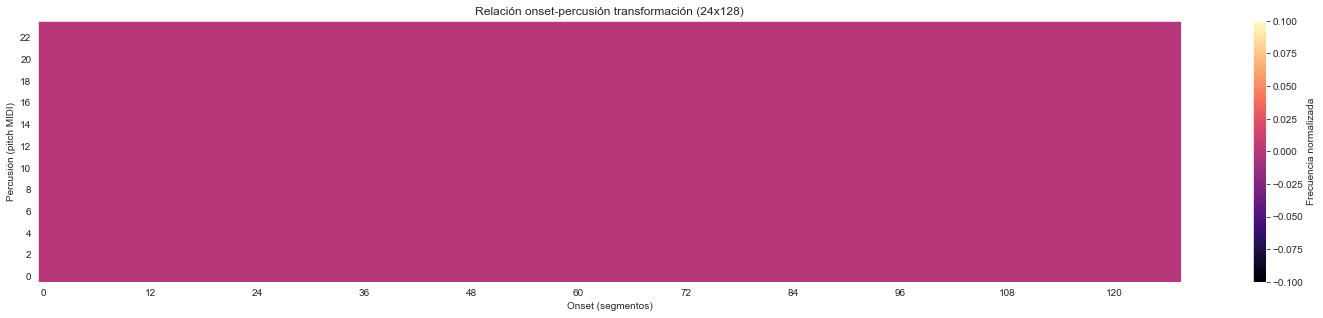

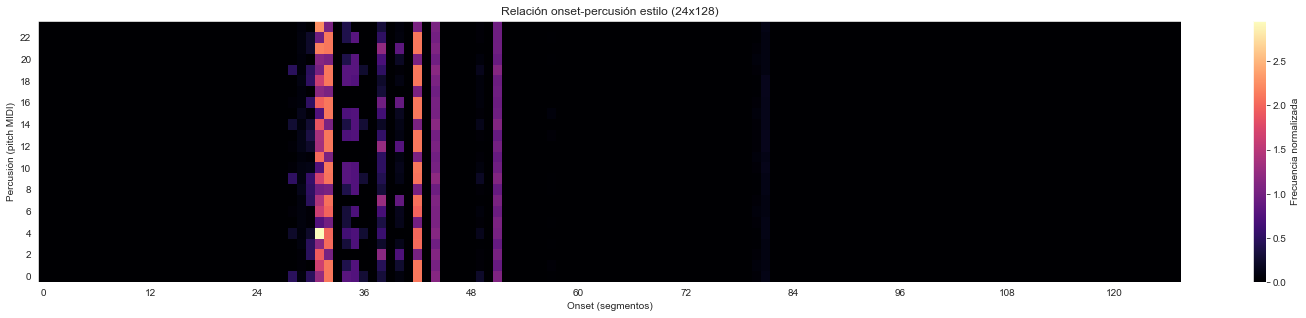

In [126]:
plot_profile_heatmap(tp_profile, title="Relación tiempo-tono transformación (24x41)", 
                     ejes=("Tiempo (segmentos)", "Tono (semitonos)"))
plot_profile_heatmap(tp_mean, title="Relación tiempo-tono estilo (24x41)",
                     ejes=("Tiempo (segmentos)", "Tono (semitonos)"))
plot_profile_heatmap(od_profile, title="Relación onset-duración transformación (24x12)", 
                     ejes=("Onset (segmentos)", "Duración (segmentos)"))
plot_profile_heatmap(od_mean, title="Relación onset-duración estilo (24x12)", 
                     ejes=("Onset (segmentos)", "Duración (segmentos)"))
plot_profile_heatmap(ov_profile, title="Relación onset-intensidad transformación (24x8)", 
                     ejes=("Onset (segmentos)", "Intensidad (velocity MIDI)"))
plot_profile_heatmap(ov_mean, title="Relación onset-intensidad estilo (24x8)", 
                     ejes=("Onset (segmentos)", "Intensidad (velocity MIDI)"))
plot_profile_heatmap(drum_profile, title="Relación onset-percusión transformación (24x128)", 
                     ejes=("Onset (segmentos)", "Percusión (pitch MIDI)"))
plot_profile_heatmap(drum_mean, title="Relación onset-percusión estilo (24x128)", 
                     ejes=("Onset (segmentos)", "Percusión (pitch MIDI)"))

# Pintar parejas

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_two_heatmaps(profile1, profile2, title1="Perfil 1", title2="Perfil 2", ejes=("Eje X", "Eje Y")):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for ax, profile, title in zip(axs, [profile1, profile2], [title1, title2]):
        bins_y, bins_x = profile.shape
        im = ax.imshow(profile, origin='lower', aspect='auto', cmap='magma')
        step_x = max(1, bins_x // 10)
        step_y = max(1, bins_y // 10)
        ax.set_xticks(np.arange(0, bins_x, step_x))
        ax.set_yticks(np.arange(0, bins_y, step_y))
        ax.grid(False)
        ax.set_title(title)
        ax.set_xlabel(ejes[0])
        ax.set_ylabel(ejes[1])
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

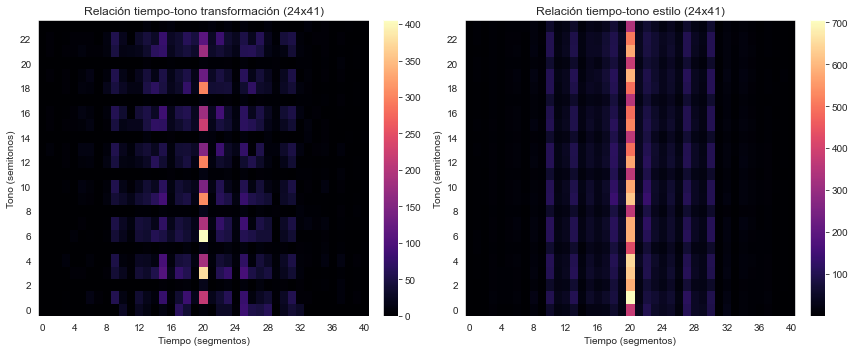

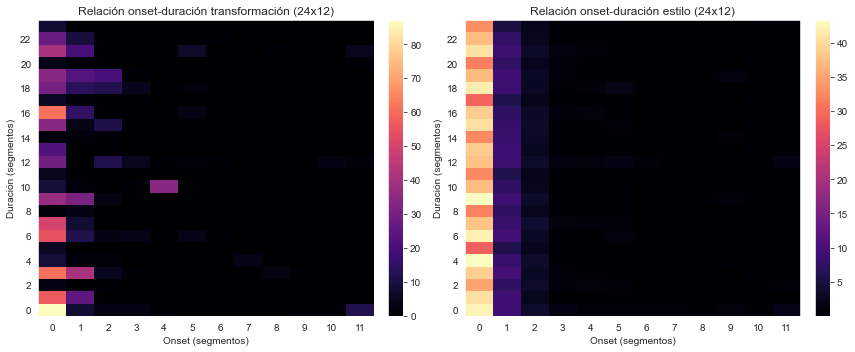

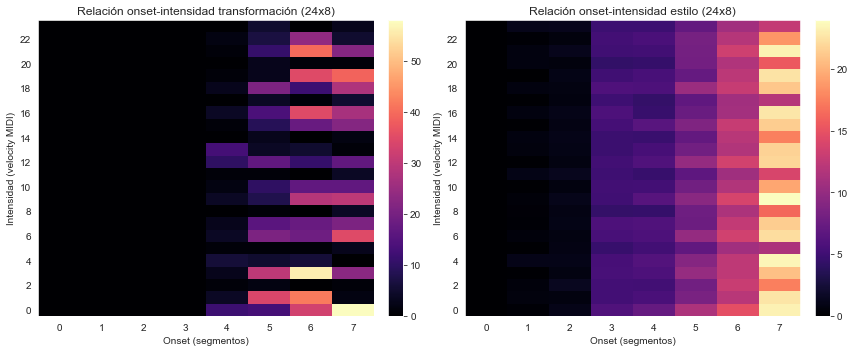

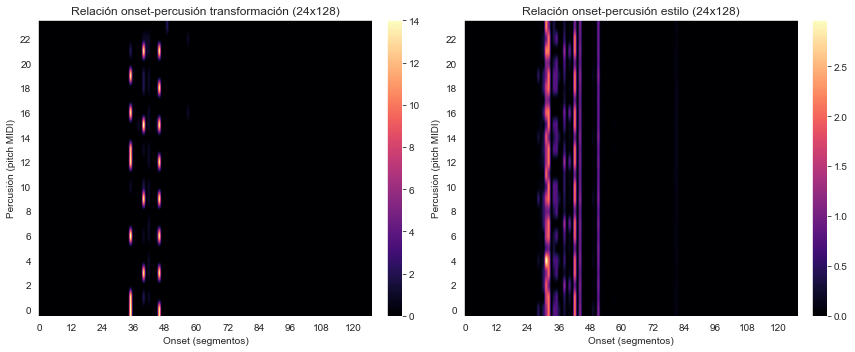

In [19]:
plot_two_heatmaps(tp_profile, tp_mean, 
                   title1="Relación tiempo-tono transformación (24x41)", 
                   title2="Relación tiempo-tono estilo (24x41)",
                   ejes=("Tiempo (segmentos)", "Tono (semitonos)"))
plot_two_heatmaps(od_profile, od_mean, 
                   title1="Relación onset-duración transformación (24x12)", 
                   title2="Relación onset-duración estilo (24x12)",
                   ejes=("Onset (segmentos)", "Duración (segmentos)"))
plot_two_heatmaps(ov_profile, ov_mean, 
                   title1="Relación onset-intensidad transformación (24x8)", 
                   title2="Relación onset-intensidad estilo (24x8)",
                   ejes=("Onset (segmentos)", "Intensidad (velocity MIDI)"))
plot_two_heatmaps(drum_profile, drum_mean, 
                   title1="Relación onset-percusión transformación (24x128)", 
                   title2="Relación onset-percusión estilo (24x128)",
                   ejes=("Onset (segmentos)", "Percusión (pitch MIDI)"))